In [7]:
import scipy.io as sio
import yaml
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from torch import nn

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor
from sklearn.preprocessing import StandardScaler

import utils as u
import RPNetRFextractor as rp

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split

configuration = yaml.safe_load(open('config.yaml'))
data_path= configuration["data"]



### Helper functions

In [8]:
def load_data(ds:str):
    """ Load data from the dataset specified by the user"""
    data = sio.loadmat(data_path[ds]["img"])
    labels = sio.loadmat(data_path[ds]["labels"])
    return data[list(data.keys())[-1]], labels[list(labels.keys())[-1]]

def extract_random_pixel(X, label):
    long, larg, depth = X.shape
    assert long == label.shape[0] and larg == label.shape[1]
    x = np.random.randint(long)
    y = np.random.randint(larg)
    return (X[x, y, :], label[x, y])

def balanced_split(y):
    """Returns the mask for a balanced split train-test"""
    classes = np.unique(y)
    unsup_mask = (y==0) # some pixels are not that usefull : did not get any label

    train_mask = (y==-1) # false everywhere, shaped as y
    test_mask = (y==-1) # false everywhere, shaped as y

    for i in classes:
        if i>0:
            col, rows = np.where(y==i)
            col_train, col_test, row_train, row_test = train_test_split(col, rows, test_size=0.2)
            train_mask[col_train, row_train] = True
            test_mask[col_test, row_test] = True
    return train_mask, test_mask, unsup_mask

def extract_tiles(X, number, w):

    patches_top_left_corners = [(np.random.randint(X.shape[0]-w), np.random.randint(X.shape[1]-w)) for i in range(number)]
    X_patches = []
    y_patches = []
    for a, b in patches_top_left_corners:
        X_patches.append(X[a:a+w, b:b+w, :])
    return np.array(X_patches)


In [9]:
X1, y1 = load_data("KSC")
X2, y2 = load_data("IP")
X3, y3 = load_data("PU")

print(X1.shape, y1.shape, X2.shape, y2.shape, X3.shape, y3.shape)

X, y= X1, y1

(512, 614, 176) (512, 614) (145, 145, 220) (145, 145) (610, 340, 103) (610, 340)


In [10]:
tensor = rp.RPNet_RF(X1)

Conv 1 done, shape : torch.Size([512, 614, 50])
Conv 2 done, shape : torch.Size([512, 614, 50])
Conv 3 done, shape : torch.Size([512, 614, 50])
Conv 4 done, shape : torch.Size([512, 614, 50])
We keep 34 principal components to keep 99.95% of the variance.


In [6]:
tensor.shape

torch.Size([512, 614, 213])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


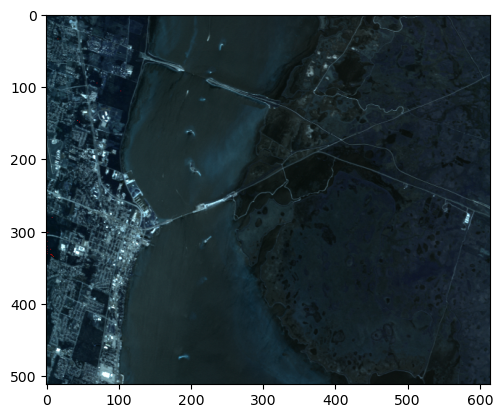

In [4]:
plt.imshow(X1[:,:, [3, 9, 12]])

In [6]:
values1 = np.unique(y1, return_counts=True)
values2 = np.unique(y2, return_counts=True)
values3 = np.unique(y3, return_counts=True)

In [7]:
train_mask1, test_mask1, unsup_mask1 = balanced_split(y1)
train_mask2, test_mask2, unsup_mask2 = balanced_split(y2)

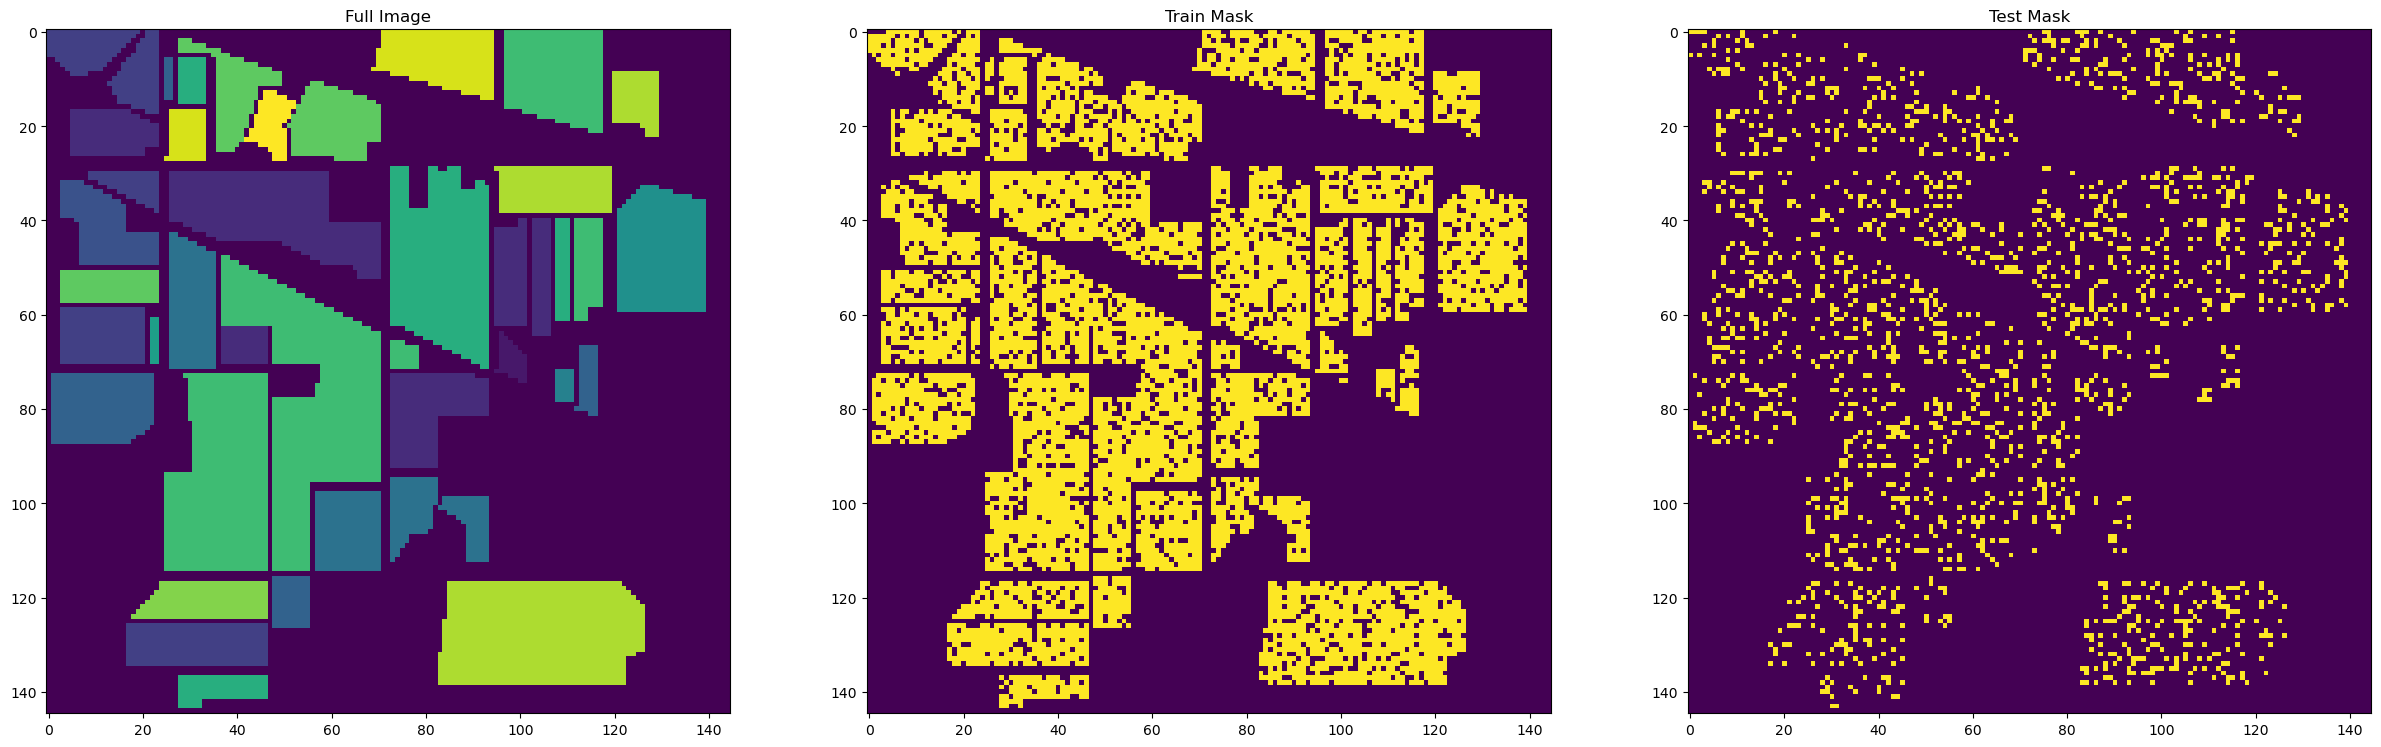

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))
ax[0].imshow(y2)
ax[0].title.set_text("Full Image")
ax[1].imshow(train_mask2)
ax[1].title.set_text("Train Mask")
ax[2].imshow(test_mask2)
ax[2].title.set_text("Test Mask")

# paper replication

In [9]:
# CONSTATNS for RPNet-RF:
parameters = configuration["parameters"]
p = 4 # number of PC in PCA
L = 4 # network depth
k = 50 # number of patches
w = 15 # size of patches
delta_s = 50 # spatial standard deviation
delta_r = 0.5 # Range standard deviation


In [16]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA



### Patch extraction:

In [ ]:
tensor

In [25]:
def one_extraction(A, params=parameters):
    """One extraction of features in the RPNet method. A is in the shape (long, larg, prof)"""
    device = "cuda" if torch.cuda.is_available() else "mps"
    long, larg, _ = A.shape
    p = params["p"]  # number of PC in PCA
    k = params["k"]  # number of patches
    w = params["w"]  # size of patches

    scaler = StandardScaler()
    pca_white = PCA(n_components=p, whiten=True)

    A = A.reshape(long * larg, -1)
    A = scaler.fit_transform(A)
    feat_map = pca_white.fit_transform(A).reshape(long, larg, p)  # feature map: PCA(X)
    patches = u.extract_tiles(feat_map, k, w)

    tensor_patches = torch.from_numpy(patches).to(torch.float32).to(device).unsqueeze(1)
    tensor_map = torch.from_numpy(feat_map).to(torch.float32).to(device).unsqueeze(0)

    res = nn.functional.conv3d(
        tensor_map,
        weight=tensor_patches,
        bias=None,
        padding=(w // 2, w // 2, 0),
        dilation=1,
        groups=1,
    )
    # reshape the tensor to apply the next PCA
    extracted_map = res.squeeze(0).squeeze(-1).permute(1, 2, 0).to("cpu")
    print(f"one conv done, shape : {extracted_map.shape}")
    return extracted_map



def RPNet_extractor(X, params=parameters):
    """ Feature extraction using RPNet method"""

    L = params["L"] # network depth
    k = params["k"] # number of patches
    long, larg, _ = X.shape
    extracted_map = X.copy()
    feature_maps = []

    for i in range(L):
        # input : X, or last extracted map (long, larg, k), output : new extracted map (long, larg, k) also appended to feature maps 
        extracted_map = one_extraction(extracted_map, params)
        feature_maps.append(extracted_map)

    feature_maps_tensor= torch.cat(feature_maps, dim=2)

    # final PCA to find the right number of PC ("Q" in the paper)

    pca = PCA()
    S = StandardScaler()
    feature_maps_tensor = S.fit_transform(feature_maps_tensor.reshape(-1, L*k))
    pca.fit(feature_maps_tensor)
    Q = pca.explained_variance_ratio_.cumsum().searchsorted(0.9995, side="right")

    print(f"We keep {Q+1} principal components to keep 99.95% of the variance.")
    pca = PCA(n_components=Q+1)
    extracted_maps = pca.fit_transform(feature_maps_tensor)
    
    return torch.from_numpy(extracted_maps.reshape(long, larg, -1)).to(torch.float32)


In [22]:
X, tensor = RPNet_extractor(X1)

NameError: name 'RPNet_extractor' is not defined

challenge the dependance on seed

## Recursive filtering

In [21]:
def RF_horizontal(tensor, params = parameters):
    """ Recursive filtering in the horizontal direction
        Paper formulas : 
            J[n] = (1-a**d)*I[n] + a**d*J[n-1]
            a = exp(-sqrt(2)/delta_s)

            d = Integral(x_(n-1), x_n, 1+ delta_s/delta_r * |I'[n]|)
                i.e. d = 1+ delta_s/delta_r* |I[n] - I[n-1]| (as x_n-1 and x_n are adjacent pixels)
        Return J, the filtered tensor
    """
    delta_s, delta_r= params["delta_s"], params["delta_r"]

    if len(tensor.shape) == 2:
        tensor = tensor.unsqueeze(2)
    _, larg, _ = tensor.shape

    filtered_tensor = np.zeros_like(tensor)
    
    # pb : recursive filtering is not 
    for n in range(larg):
        if n==0:
            filtered_tensor[:, n, :] = tensor[:, n, :]
        else:
            d = 1+ delta_s/delta_r* torch.abs(tensor[:,n,:] - tensor[:,n-1,:])
            a_d = torch.exp(-torch.sqrt(torch.tensor(2))*d /delta_s)
            filtered_tensor[:,n,:]= (1 - a_d)*tensor[:,n,:] + a_d * filtered_tensor[:,n-1,:]
    return torch.tensor(filtered_tensor)


def RF_vertical(tensor, params=parameters):
    """ Recursive filtering in the horizontal direction
        Paper formulas : 
            J[n] = (1-a**d)*I[n] + a**d*J[n-1]
            a = exp(-sqrt(2)/delta_s)

            d = Integral(x_(n-1), x_n, 1+ delta_s/delta_r * |I'[n]|)
                i.e. d = 1+ delta_s/delta_r* |I[n] - I[n-1]| (as x_n-1 and x_n are adjacent pixels)
        Return J, the filtered tensor
    """
    
    delta_s, delta_r= params["delta_s"], params["delta_r"]
    if len(tensor.shape) == 2:
        tensor = tensor.unsqueeze(2)
    long, _, _ = tensor.shape

    filtered_tensor = np.zeros_like(tensor)
    
    # pb : recursive filtering is not 
    for n in range(long):
        if n==0:
            filtered_tensor[n, :, :] = tensor[n, :, :]
        else:
            d = 1+ delta_s/delta_r* torch.abs(tensor[n, :, :] - tensor[n-1, :, :])
            a_d = torch.exp(-torch.sqrt(torch.tensor(2))*d /delta_s)
            filtered_tensor[n, :, :]= (1 - a_d)*tensor[n, :, :] + a_d * filtered_tensor[n-1, :, :]
    return torch.tensor(filtered_tensor)

def RF(tensor, params=parameters):
    """ Applies 3 passes of recursive filtering, as mentionned in the paper : 3 vertical and 3 horizontal.
        Orignial paper on this recommends to modify the value of deltas between iterations, 
        but replicated paper doesn't so not done here.
    
    """
    tensor1h = RF_horizontal(tensor, params)
    tensor1v = RF_vertical(tensor1h, params)
    tensor2h = RF_horizontal(tensor1v, params)
    tensor2v = RF_vertical(tensor2h, params)
    tensor3h = RF_horizontal(tensor2v, params)
    tensor3v = RF_vertical(tensor3h, params)
    return tensor3v

def RPNet_RF(X, params = parameters):
    """ Full RPNet-RF method, from feature extraction to recursive filtering"""

    tensor = RPNet_extractor(X, params)
    filtered_tensor = RF(tensor, params["delta_s"], params["delta_r"])
    
    return torch.cat([torch.tensor(X), filtered_tensor], dim=2)

    

Implementing classifier : 

In [28]:
from sklearn.svm import SVC

In [ ]:
svc = 

# Using 1D convolutional neural network on the image with train and test set

In [ ]:

class Conv1DNet(nn.Module):
    def __init__(self, in_channels, classes_nb, hidden_dim1, hidden_dim2, kernel_size):
        super.__init__()

        self.convBlock = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=10, kernel_size=kernel_size),
            nn.ReLU(),
            nn.Conv1d(in_channels=10, out_channels=10, kernel_size=kernel_size),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=10, out_channels=5, kernel_size=kernel_size),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Flatten()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=220, out_features=hidden_dim1),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim1, out_features=hidden_dim2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim2, out_features=classes_nb),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.convBlock(x)
        x = self.classifier(x)
        return x


In [ ]:
EPOCH = 10
loss = nn.CrossEntropyLoss()

model= Conv1DNet(in_channels=176, classes_nb=10, hidden_dim1=128, hidden_dim2=64, kernel_size=5)
optimizer = nn.Adam(model.parameters(), lr=0.001)


In [15]:
from torch import nn
conv_layer = nn.Conv3d(in_channels=1, out_channels=1, kernel_size=(w, w, p), stride=1, padding=(w//2, w//2, 0), bias=False)

conv_layer.requires_grad_()

Conv3d(1, 1, kernel_size=(15, 15, 4), stride=(1, 1, 1), padding=(7, 7, 0), bias=False)